# <div align="center">Ant Colony Algorithm For Travelling Salesman Problem</div>


## Import Libraries:

In [1]:
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt

## City and Chromosome Classes:

In [2]:
class City:
    """Class representing a city with a name and coordinates."""
    def __init__(self, name, coordinates):
        """
        Initialize a City object.

        Parameters:
            name (str or int): Name or identifier of the city.
            coordinates (list): List containing x and y coordinates of the city.
        """
        self.name = name
        self.coordinates = coordinates

    def __repr__(self):
        """String representation of a City object."""
        return f"City: {self.name}"

    def __eq__(self, other):
        """Check if two City objects are equal."""
        return self.name == other.name

class Chromosome:
    """Class representing a chromosome in the genetic algorithm."""
    def __init__(self, genes):
        """
        Initialize a Chromosome object.

        Parameters:
            genes (list): List of City objects representing the chromosome's genes.
        """
        self.fitness = 0 
        self.cost = 0 
        self.genes = genes

    def __repr__(self):
        """String representation of a Chromosome object."""
        return f'Genes: {self.genes} Total Cost: {self.cost} Fitness Score: {self.fitness}'

## Reading Data:

In [3]:
def read_data(path):
    """
    Read city data from a CSV file and create City objects.

    Parameters:
        path (str): Path to the CSV file containing city data.

    Returns:
        list: List of City objects.
    """
    df = pd.read_csv(path)
    cities = []
    for index, row in df.iterrows():
        city_name = int(row['City'])  
        cities.append(City(city_name, [row['x'], row['y']]))
    return cities

## Distance Calculation:

In [4]:
def calculate_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
        point1 (list): List containing x and y coordinates of the first point.
        point2 (list): List containing x and y coordinates of the second point.

    Returns:
        float: Euclidean distance between the two points.
    """
    point1 = np.array(point1, dtype=float)
    point2 = np.array(point2, dtype=float)
    distance = np.sum((point1 - point2) ** 2) ** 0.5
    return distance

def create_distance_matrix(cities):
    """
    Create a distance matrix based on the pairwise distances between cities.

    Parameters:
        cities (list): List of City objects.

    Returns:
        numpy.ndarray: 2D array representing the distance matrix.
    """
    distance_matrix = np.zeros((len(cities), len(cities)))
    for i in range(len(cities)):
        for j in range(len(cities)):
            if i != j:
                distance_matrix[i, j] = calculate_distance(cities[i].coordinates, cities[j].coordinates)
    return distance_matrix

## Calculate Chromosome Cost:

In [5]:
def calculate_chromosome_cost(chromosome, distance_matrix):
    """
    Calculate the total cost of traversing a chromosome's genes.

    Parameters:
        chromosome (Chromosome): Chromosome object containing the genes.
        distance_matrix (numpy.ndarray): Distance matrix between cities.

    Returns:
        float: Total cost of traversing the chromosome.
    """
    total_distance = 0
    for i in range(len(chromosome.genes) - 1):
        city1 = chromosome.genes[i]
        city2 = chromosome.genes[i + 1]
        total_distance += distance_matrix[city1.name - 1, city2.name - 1]
    return total_distance + calculate_distance(chromosome.genes[-1].coordinates, chromosome.genes[0].coordinates)

## Create Initial Population:

In [6]:
def create_initial_population(num, distance_matrix):
    """
    Create an initial population of chromosomes.

    Parameters:
        num (int): Number of chromosomes in the population.
        distance_matrix (numpy.ndarray): Distance matrix between cities.

    Returns:
        list: Initial population of Chromosome objects.
    """
    cities = read_data('Data set CSV.csv')
    population = []
    for _ in range(num):
        chromosome = Chromosome(list(np.random.permutation(cities)))
        chromosome.cost = calculate_chromosome_cost(chromosome, distance_matrix)
        chromosome.fitness = 1 / chromosome.cost 
        population.append(chromosome)
    return population

## Select Better Solution:

In [8]:
def select_better_solution(solution1, solution2):
    """
    Select the better solution between two solutions based on cost.

    Parameters:
        solution1 (Chromosome): First solution.
        solution2 (Chromosome): Second solution.

    Returns:
        Chromosome: Better solution.
    """
    if solution1.cost < solution2.cost:
        return solution1
    else:
        return solution2

## Update Pheromone Matrix:

In [9]:
def update_pheromone_matrix(old_pheromone, population, evaporation_rate):
    """
    Update the pheromone matrix based on the population's solutions.

    Parameters:
        old_pheromone (numpy.ndarray): Current pheromone matrix.
        population (list): List of Chromosome objects representing the population.
        evaporation_rate (float): Rate at which pheromone evaporates.

    Returns:
        numpy.ndarray: Updated pheromone matrix.
    """
    new_pheromone = copy.deepcopy(old_pheromone) * (1 - evaporation_rate)
    for chromosome in population:
        pheromone_value = 1 / chromosome.cost
        for i in range(len(chromosome.genes) - 1):
            city1_index = chromosome.genes[i].name - 1
            city2_index = chromosome.genes[i + 1].name - 1
            new_pheromone[city1_index, city2_index] += pheromone_value
            new_pheromone[city2_index, city1_index] += pheromone_value
    return new_pheromone

## Construct Solution:

In [10]:
def construct_solution(cities, pheromone_matrix, distance_matrix, alpha, beta, size):
    """
    Construct a new solution using the ant colony algorithm.

    Parameters:
        cities (list): List of City objects.
        pheromone_matrix (numpy.ndarray): Pheromone matrix representing the trails.
        distance_matrix (numpy.ndarray): Distance matrix between cities.
        alpha (float): Influence of pheromone on decision making.
        beta (float): Influence of distance on decision making.
        size (int): Number of solutions to construct.

    Returns:
        list: List of Chromosome objects representing the new solutions.
    """
    new_generation = []
    while True:
        random_index = random.choices(range(len(cities)))[0]
        current_city = cities[random_index]
        path = [current_city]
        unvisited_cities = [city for city in cities]
        for _ in range(len(cities) - 1):
            probabilities = []
            unvisited_cities.remove(current_city)
            for city in cities:
                if city in path:
                    continue
                probability = (((pheromone_matrix[current_city.name - 1, city.name - 1]) ** alpha) * 
                               ((1 / distance_matrix[current_city.name - 1, city.name - 1]) ** beta))
                probabilities.append(probability)
            probabilities = np.array(probabilities) / np.sum(probabilities)
            next_city = np.random.choice(unvisited_cities, p=probabilities)
            path.append(next_city)
            current_city = next_city
        chromosome = Chromosome(path)
        new_generation.append(chromosome)
        if len(new_generation) == size:
            return new_generation


## Sort Population By Fitness:

In [11]:
def sort_population_by_fitness(population):
    """
    Sort the population by fitness in descending order.

    Parameters:
        population (list): List of Chromosome objects representing the population.

    Returns:
        list: Population sorted by fitness.
    """
    population = sorted(population, key=lambda x: x.fitness, reverse=True)
    return population

## Evaluate Population:

In [12]:
def evaluate_population(population, distance_matrix):
    """
    Evaluate the fitness of the population's chromosomes.

    Parameters:
        population (list): List of Chromosome objects representing the population.
        distance_matrix (numpy.ndarray): Distance matrix between cities.

    Returns:
        list: Population sorted by fitness.
    """
    updated_population = [] 
    for chromosome in population:
        chromosome.cost = calculate_chromosome_cost(chromosome, distance_matrix)
        chromosome.fitness = 1 / chromosome.cost
        updated_population.append(chromosome)
    return sort_population_by_fitness(updated_population)

## Main Algorithm Execution:

In [13]:
if __name__ == "__main__":
    population_size = 100
    alpha = 1
    beta = 2
    num_generations = 10
    initial_pheromone_matrix = np.zeros((15, 15)) + 0.000000000001
    evaporation_rate = 0.7

    cities = read_data('Data set CSV.csv')
    distance_matrix = create_distance_matrix(cities)
    population = create_initial_population(population_size, distance_matrix)
    pheromone_matrix = update_pheromone_matrix(initial_pheromone_matrix, population, evaporation_rate)

    best_solutions_for_all_generations = []

    for _ in range(num_generations):   
        population = construct_solution(cities, pheromone_matrix, distance_matrix, alpha, beta, population_size)
        population = evaluate_population(population, distance_matrix)
        best_solutions_for_all_generations.append(population[0])
        pheromone_matrix = update_pheromone_matrix(pheromone_matrix, population, evaporation_rate)

    best_solution = sort_population_by_fitness(best_solutions_for_all_generations)[0]
    best_solution.genes.append(best_solution.genes[0])
    print(best_solution)

Genes: [City: 5, City: 9, City: 15, City: 2, City: 13, City: 1, City: 11, City: 4, City: 6, City: 8, City: 10, City: 14, City: 12, City: 3, City: 7, City: 5] Total Cost: 284.3810904080331 Fitness Score: 0.0035164082062038265


## Plotting Function:

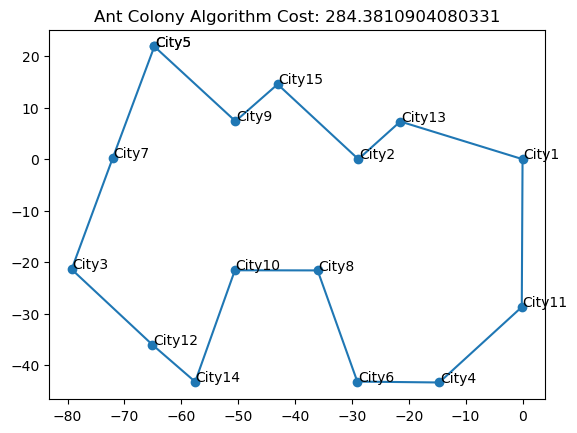

In [15]:
def plot_solution(solution):
    """
    Plot the solution path on a 2D plane.

    Parameters:
        solution (Chromosome): Chromosome object representing the solution path.
    """
    x = []
    y = []
    names = []
    for city in solution.genes:
        x.append(float(city.coordinates[0]))
        y.append(float(city.coordinates[1]))
        names.append('City' + str(city.name))
    fig, ax = plt.subplots()
    def animate(i):
        ax.clear()
        ax.plot(x[:i+1], y[:i+1], marker='o')
    plt.plot(x, y, marker='o')
    for i in range(len(x)):
        plt.text(x[i] + 0.1, y[i] + 0.1, names[i], fontsize=10)
    plt.title(f'Ant Colony Algorithm Cost: {best_solution.cost}')
    plt.show()

plot_solution(best_solution)